In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Definieer wat waardes voor je k's
k1 = 100000000       # kon for E + S to ES
k2 = 100                # koff for ES to E + S
k3 = 100000000
k4 = 10
k5 = 0.001
k6 = 0
kcat = 1

# Definieer de concentraties op T=0 (in eerste instantie: voor inhibitie of substraat)
E0 = 100*10**-12
ES0 = 0
P0 = 0
EI0 = 0
EIi0 = 0  #(EI*)

#Definieer constanten
Is = [1*10**-6, 0.5*10**-6, 0.25*10**-6, 0.15*10**-6, 0.075*10**-6, 0.04*10**-6, 0.02*10**-6, 10*10**-9, 5*10**-9, 2.5*10**-9, 1.0*10**-9, 0*10**-9]
S0 = 1000*10**-9
dt = 0.001 #Dit is hoe groot je simulatie tijdstappen zijn

tframe = 60 #save a frame every 60 s
tincub = 0 #incubate for 1800 s
tsub = 7200  # Run with substrate for 1800 s

In [3]:
all_plots = []

In [4]:
for I in Is:
  concentraties = np.array([E0, ES0, P0, EI0, EIi0], dtype=np.double) #matrix van concentraties
  # Voor toevoeging van S

  S=0 # Geen S in je systeem

                          # [         E,       ES, P,     EI, EI*]
  tijdevolutie0 = np.array([[-k3*I-k1*S,  k2+kcat, 0,     k4,   0],  #E
                            [      k1*S, -k2-kcat, 0,      0,   0],  #ES
                            [         0,     kcat, 0,      0,   0],  #P
                            [      k3*I,        0, 0, -k4-k5,  k6],  #EI
                            [         0,        0, 0,     k5, -k6]]) #EI*

  #verandering in E   = [E]*(-k3*I-k1*S) + [ES]*(k2+kcat)  + [P]*(0) + [EI]*(k4)     + [EI*]*(0)
  #verandering in ES  = [E]*(k1*S)       + [ES]*(-k2-kcat) + [P]*(0) + [EI]*(0)      + [EI*]*(0)
  #verandering in P   = [E]*(0)          + [ES]*(kcat)     + [P]*(0) + [EI]*(0)      + [EI*]*(0)
  #verandering in EI  = [E]*(k3*I)       + [ES]*(0)        + [P]*(0) + [EI]*(-k4-k5) + [EI*]*(k6)
  #verandering in EI* = [E]*(0)          + [ES]*(0)        + [P]*(0) + [EI]*(k5)     + [EI*]*(-k6)

  # Maak een lijst van kopien van de concentraties
  plot = [concentraties.copy()]

  tijdconc = concentraties
  t = 0
  # Voor toevoging van S (tincub/dt stappen = 30min)
  for i in range(int(tincub/dt)):
      t+= 1
      tijdconc += np.dot(tijdevolutie0*dt, tijdconc) # Doe 1 dt tijdstap
      if (tijdconc < 0).any():
          raise ValueError("got a negative concentration, try decreasing dt")


      if t % int(tframe/dt)==0:
          plot.append(tijdconc.copy()) # Voeg de nieuwe concentraties toe aan de lijst

  # Na toevoeging van S (tsub/dt stappen)
  for i in range(int(tsub/dt)):
      t += 1
      S= S0-(tijdconc[2]+tijdconc[1]) #Subtract P and ES from S
      tijdevolutie1 = np.array([[-k3*I-k1*S, k2+kcat, 0, k4, 0],
                           [k1*S, -k2-kcat, 0, 0, 0],
                           [0, kcat, 0, 0, 0],
                           [k3*I, 0, 0, -k4-k5, k6],
                           [0, 0, 0, k5, -k6]])
      tijdconc += np.dot(tijdevolutie1*dt, tijdconc) #Doe 1 dt tijdstap
      if (tijdconc < 0).any():
          raise ValueError("got a negative concentration, try decreasing dt")


      if t % int(tframe/dt)==0:
          plot.append(tijdconc.copy()) # Voeg de nieuwe concentraties toe aan de lijst
  all_plots.append(plot)

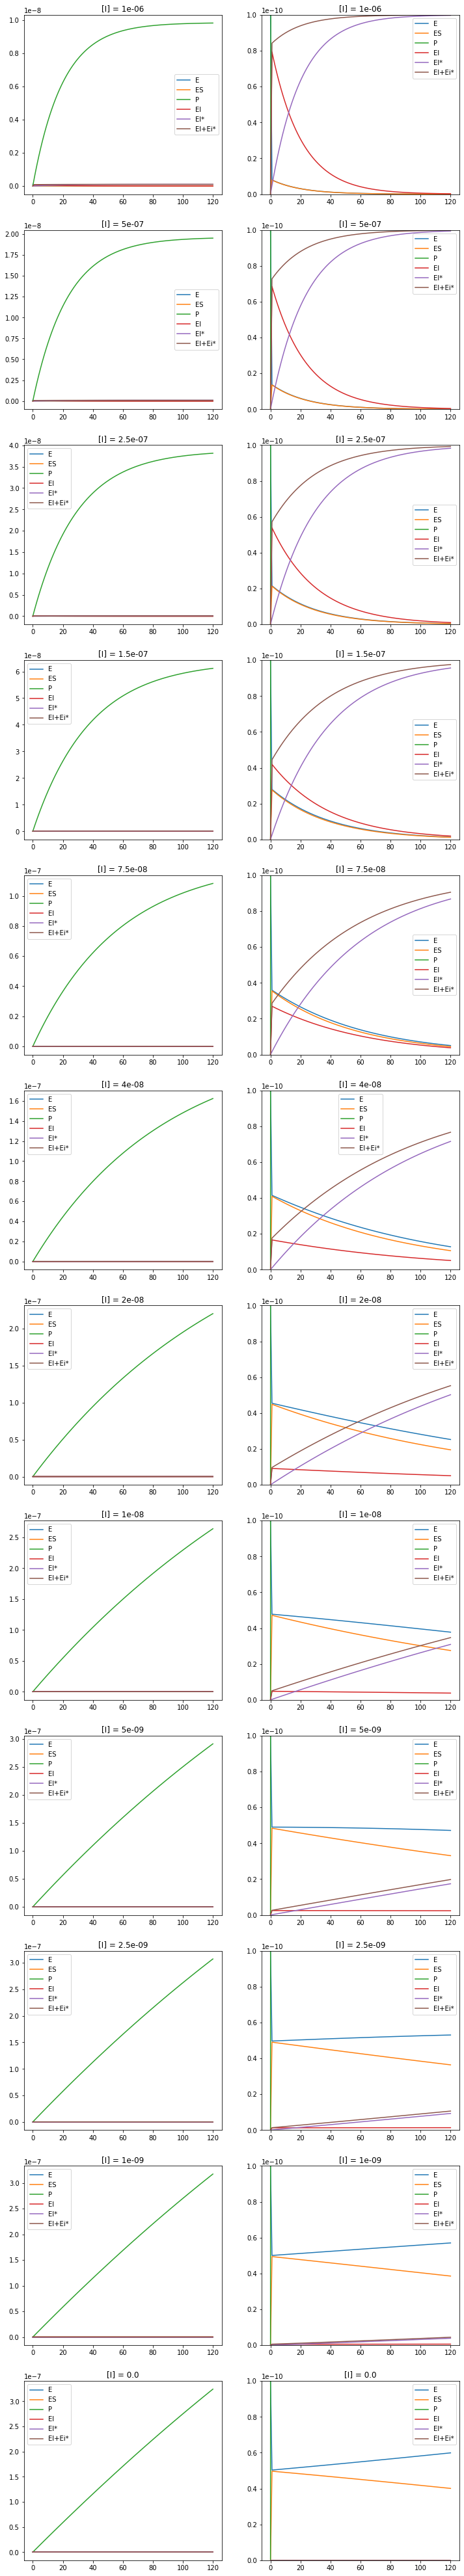

In [5]:
# This will make all the plots and dataframes
dataframes = []
fig, axes = plt.subplots(len(all_plots), 2, figsize=(12,len(all_plots)*6))
for n, plot in enumerate(all_plots):
  # Splits de lijst van figuren in E, ES, P, EI en EI*
  Eplot = [] 
  ESplot = []
  Pplot = []
  EIplot = []
  EIiplot = []
  EItot = []
  for frame in plot:
    Eplot.append(frame[0])
    ESplot.append(frame[1])
    Pplot.append(frame[2])
    EIplot.append(frame[3])
    EIiplot.append(frame[4])
    EItot.append(frame[3]+frame[4]) 
    
   # Plot de figuren
  labels = ('E', 'ES', "P", "EI", "EI*", "EI+Ei*")
  for i,y in enumerate((Eplot, ESplot, Pplot, EIplot, EIiplot, EItot)):
    axes[n,0].plot(y, label=labels[i])
  axes[n,0].legend()
  for i,y in enumerate((Eplot, ESplot, Pplot, EIplot, EIiplot, EItot)):
      axes[n,1].plot(y, label=labels[i])
  axes[n,1].legend()
  axes[n,1].set_ylim(0,E0) #zoom in tot E0
  axes[n,0].set_title("[I] = {}".format(str(Is[n])))
  axes[n,1].set_title("[I] = {}".format(str(Is[n])))
  
  df = pd.DataFrame(data={'E':Eplot,  "EI":EIplot, "EIi":EIiplot, "ES":ESplot, "P":Pplot})
  dataframes.append(df)
df = pd.concat(dataframes, keys=[I for I in Is], axis=1) # Combine all the dataframes

In [6]:
df

0.000001                              ... 0.000000                            
                E            EI           EIi  ...      EIi            ES             P
0    1.000000e-10  0.000000e+00  0.000000e+00  ...      0.0  0.000000e+00  0.000000e+00
1    7.933654e-12  7.933522e-11  4.879818e-12  ...      0.0  4.967533e-11  2.982513e-09
2    7.546678e-12  7.546553e-11  9.522876e-12  ...      0.0  4.960054e-11  5.960790e-09
3    7.178551e-12  7.178432e-11  1.393945e-11  ...      0.0  4.952564e-11  8.934577e-09
4    6.828357e-12  6.828244e-11  1.814058e-11  ...      0.0  4.945064e-11  1.190387e-08
..            ...           ...           ...  ...      ...           ...           ...
116  2.505297e-14  2.505256e-13  9.969986e-11  ...      0.0  4.042778e-11  3.145388e-07
117  2.382918e-14  2.382878e-13  9.971452e-11  ...      0.0  4.034252e-11  3.169619e-07
118  2.266516e-14  2.266479e-13  9.972847e-11  ...      0.0  4.025719e-11  3.193799e-07
119  2.155801e-14  2.155765e-13  9.974173e-11  ...      0.0  4.017181e-11  3.217928e-07
120  2.050494e-14  2.050460e-13  9.975435e-11  ...      0.0  4.008636e-11  3.242005e-07

[121 rows x 60 columns]

In [7]:
print(df.to_csv())

,1e-06,1e-06,1e-06,1e-06,1e-06,5e-07,5e-07,5e-07,5e-07,5e-07,2.5e-07,2.5e-07,2.5e-07,2.5e-07,2.5e-07,1.5e-07,1.5e-07,1.5e-07,1.5e-07,1.5e-07,7.5e-08,7.5e-08,7.5e-08,7.5e-08,7.5e-08,4e-08,4e-08,4e-08,4e-08,4e-08,2e-08,2e-08,2e-08,2e-08,2e-08,1e-08,1e-08,1e-08,1e-08,1e-08,5e-09,5e-09,5e-09,5e-09,5e-09,2.5e-09,2.5e-09,2.5e-09,2.5e-09,2.5e-09,1e-09,1e-09,1e-09,1e-09,1e-09,0.0,0.0,0.0,0.0,0.0
,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P
0,1e-10,0.0,0.0,0.0,0.0,1e-10,0.0,0.0,0.0,0.0,1e-10,0.0,0.0,0.0,0.0,1e-10,0.0,0.0,0.0,0.0,1e-10,0.0,0.0,0.0,0.0,1e-10,0.0,0.0,0.0,0.0,1e-10,0.0,0.0,0.0,0.0,1e-10,0.0,0.0,0.0,0.0,1e-10,0.0,0.0,0.0,0.0,1e-10,0.0,0.0,0.0,0.0,1e-10,0.0,0.0,0.0,0.0,1e-10,0.0,0.0,0.0,0.0
1,7.933654284597995e-12,7.933522115770556e-11,4.879817767142102e-12,7.851306790559435e-12,4.837853806634854e-10,1.3707101385696101e-11,6.853354314754104e-11,4.199352592967395